In [1]:
%matplotlib inline


# Robust line model estimation using RANSAC


In this example we see how to robustly fit a line model to faulty data using
the RANSAC (random sample consensus) algorithm.

Firstly the data are generated by adding a gaussian noise to a linear function.
Then, the outlier points are added to the data set.

RANSAC iteratively estimates the parameters from the data set.
At each iteration the following steps are performed:

1. Select ``min_samples`` random samples from the original data and check
   whether the set of data is valid (see ``is_data_valid`` option).
2. Estimate a model on the random subset
   (``model_cls.estimate(*data[random_subset]``) and check whether the
   estimated model is valid (see ``is_model_valid`` option).
3. Classify all the data points as either inliers or outliers by calculating
   the residuals using the estimated model (``model_cls.residuals(*data)``) -
   all data samples with residuals smaller than the ``residual_threshold``
   are considered as inliers.
4. If the number of the inlier samples is greater than ever before,
   save the estimated model as the best model. In case the current estimated
   model has the same number of inliers, it is considered as the best model
   only if the sum of residuals is lower.

These steps are performed either a maximum number of times or until one of
the special stop criteria are met. The final model is estimated using all the
inlier samples of the previously determined best model.




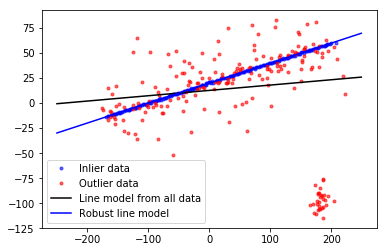

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.measure import LineModelND, ransac


np.random.seed(seed=1)

# generate coordinates of line
x = np.arange(-200, 200)
y = 0.2 * x + 20
data = np.column_stack([x, y])

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape)
data += 0.5 * noise
data[::2] += 5 * noise[::2]
data[::4] += 20 * noise[::4]

# add faulty data
faulty = np.array(30 * [(180., -100)])
faulty += 10 * np.random.normal(size=faulty.shape)
data[:faulty.shape[0]] = faulty

# fit line using all data
model = LineModelND()
model.estimate(data)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
outliers = inliers == False

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
        label='Inlier data')
ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6,
        label='Outlier data')
ax.plot(line_x, line_y, '-k', label='Line model from all data')
ax.plot(line_x, line_y_robust, '-b', label='Robust line model')
ax.legend(loc='lower left')
plt.show()

Now, we generalize this example to 3D points.



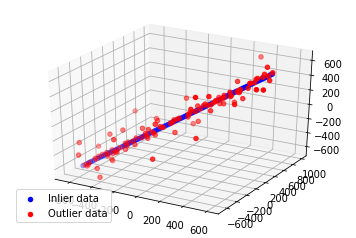

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import LineModelND, ransac

np.random.seed(seed=1)

# generate coordinates of line
point = np.array([0, 0, 0], dtype='float')
direction = np.array([1, 1, 1], dtype='float') / np.sqrt(3)
xyz = point + 10 * np.arange(-100, 100)[..., np.newaxis] * direction

# add gaussian noise to coordinates
noise = np.random.normal(size=xyz.shape)
xyz += 0.5 * noise
xyz[::2] += 20 * noise[::2]
xyz[::4] += 100 * noise[::4]

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(xyz, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
outliers = inliers == False

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[inliers][:, 0], xyz[inliers][:, 1], xyz[inliers][:, 2], c='b',
           marker='o', label='Inlier data')
ax.scatter(xyz[outliers][:, 0], xyz[outliers][:, 1], xyz[outliers][:, 2], c='r',
           marker='o', label='Outlier data')
ax.legend(loc='lower left')
plt.show()